Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.
Number of food categories: 101
Epoch 1/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 2627s 1s/step - accuracy: 0.2366 - loss: 3.3197 - val_accuracy: 0.4280 - val_loss: 2.3963
Epoch 2/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 2312s 916ms/step - accuracy: 0.3983 - loss: 2.4312 - val_accuracy: 0.4820 - val_loss: 2.1104
Epoch 3/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 2346s 929ms/step - accuracy: 0.4437 - loss: 2.2177 - val_accuracy: 0.5046 - val_loss: 2.0019
Epoch 4/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 2375s 941ms/step - accuracy: 0.4701 - loss: 2.0968 - val_accuracy: 0.5163 - val_loss: 1.9298
Epoch 5/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 2360s 935ms/step - accuracy: 0.4886 - loss: 2.0128 - val_accuracy: 0.5231 - val_loss: 1.8862
Epoch 6/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 2374s 940ms/step - accuracy: 0.5048 - loss: 1.9484 - val_accuracy: 0.5299 - val_loss: 1.8597
Epoch 7/10
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 2378s 942ms/step - accuracy: 0

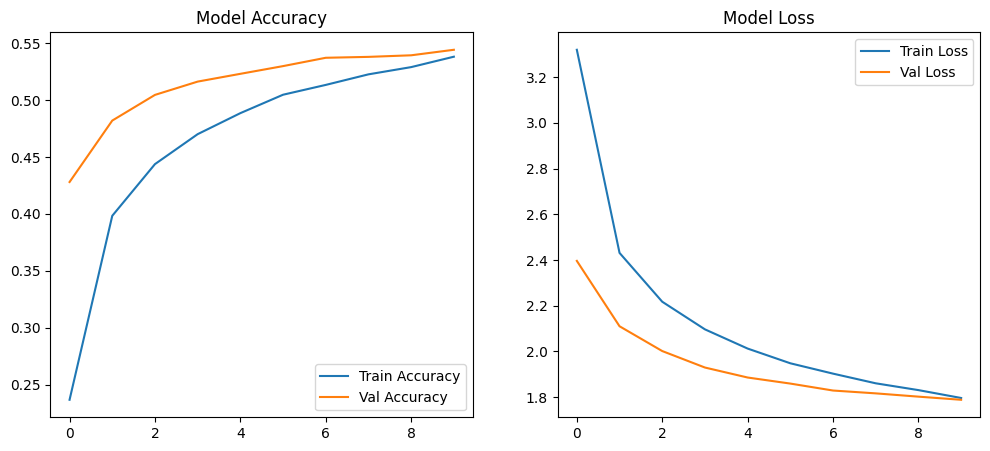

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


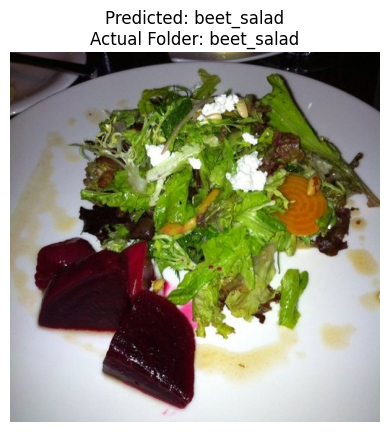

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


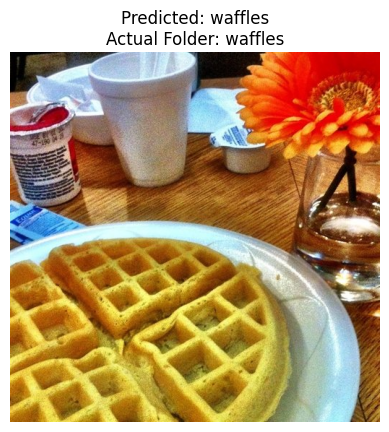

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


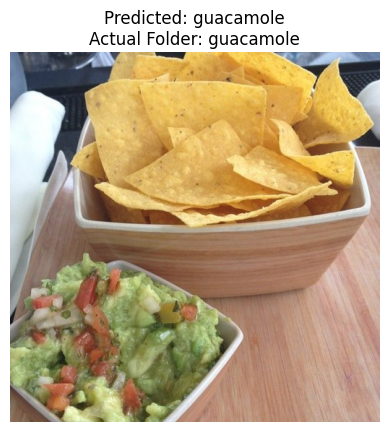

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


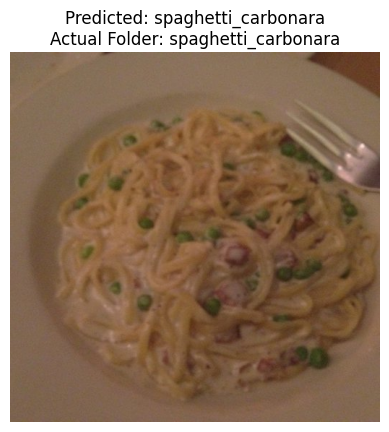

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


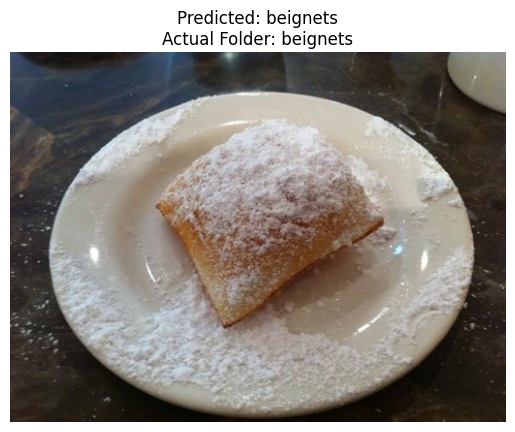

In [1]:
# !pip install tensorflow matplotlib numpy --quiet

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import random
# -------------------------------
# STEP 1: Define Dataset Path
# -------------------------------
dataset_path = r"C:\Users\HP\Downloads\food-101\food-101\images"

# The dataset is organized as:
# images/
#   ├── apple_pie/
#   ├── pizza/
#   ├── sushi/
#   ├── burger/  etc.

# -------------------------------
# STEP 2: Preprocess Images
# -------------------------------
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,        # 80-20 split
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_gen.class_indices)
print("Number of food categories:", num_classes)

# -------------------------------
# STEP 3: Load Pretrained Model (Transfer Learning)
# -------------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# -------------------------------
# STEP 4: Compile and Train
# -------------------------------
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

# -------------------------------
# STEP 5: Evaluate the Model
# -------------------------------
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n✅ Validation Accuracy: {val_acc*100:.2f}%")

# -------------------------------
# STEP 6: Visualize Accuracy & Loss
# -------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# -------------------------------
# STEP 7: Predict Random Food Images
# -------------------------------
class_labels = list(train_gen.class_indices.keys())

for i in range(5):
    random_class = random.choice(class_labels)
    img_folder = os.path.join(dataset_path, random_class)
    random_img = random.choice(os.listdir(img_folder))
    img_path = os.path.join(img_folder, random_img)

    img = tf.keras.utils.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.utils.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_label = class_labels[np.argmax(prediction)]

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.title(f"Predicted: {predicted_label}\nActual Folder: {random_class}")
    plt.axis('off')
    plt.show()
